### Final landscape selection
From the 100 preselected landscape trios, selects 20 final ones for the study.
Selects landscapes such that the sum of the absolute differences between the global and local AI values is minimised across the complete set of selected trios. Ensures that the average global and local advisor rewards match as closely as possible.

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, MultipleLocator
from common import Landscape, set_matplotlib_latex, plot_colours, set_axes_length
set_matplotlib_latex()

In [7]:
def load_preselected_landscape_trios():
    with open(f"../outputs/advisor_high_low_comparison_preselected_landscapes/advisor_high_low_comparison_preselected_landscapes.json", "r", encoding="utf-8") as file:
        landscape_trios_json = json.load(file)
    landscape_trios = []
    for landscape_trio_json in landscape_trios_json:
        trio = []
        for landscape_trio in landscape_trio_json["trio"]:
            landscape = Landscape(landscape_trio["coefficients_low"], landscape_trio["coefficients_high"], landscape_trio["block_nr1"], landscape_trio["block_nr2"], 0)
            trio.append(landscape)
        landscape_trios.append({
            "trio": trio,
            "high_rewards": np.array(landscape_trio_json["high_rewards"]),
            "low_rewards": np.array(landscape_trio_json["low_rewards"])})
    return landscape_trios

def save_selected_landscape_trios(landscape_trios, nr_trios_to_select):
    landscape_id = 0
    selected_trios_json = []
    selected_trios_with_rewards_json = []
    for landscape_trio in landscape_trios:
        selected_trio_json = []
        for landscape in landscape_trio["trio"]:
            selected_trio_json.append({
                "coefficients_low": landscape.get_coefficients_low(),
                "coefficients_high": landscape.get_coefficients_high(),
                "block_nr1": landscape.get_block_nr1(),
                "block_nr2": landscape.get_block_nr2(),
                "id": landscape_id
            })
            landscape_id += 1
        selected_trios_json.append(selected_trio_json)
        selected_trios_with_rewards_json.append({
            "trio": selected_trio_json,
            "high_rewards": landscape_trio["high_rewards"].tolist(),
            "low_rewards": landscape_trio["low_rewards"].tolist()
        })
    with open(f"../landscapes/landscape_trios_{nr_trios_to_select}.json", "w", encoding="utf-8") as file:
        json.dump(selected_trios_json, file, indent=4)
    with open(f"../landscapes/landscape_trios_{nr_trios_to_select}_with_rewards.json", "w", encoding="utf-8") as file:
        json.dump(selected_trios_with_rewards_json, file, indent=4)
        
def plot_performance(filename_figure_high_low, filename_figure_average, performance_high, performance_low, nr_trials, show=False):
    plot_width = 1.05
    plot_height = 0.7
    trial_numbers = list(range(0, nr_trials))
    plt.plot(trial_numbers, performance_high, label="Global", color=plot_colours["global"])
    plt.plot(trial_numbers, performance_low, label="Local", color=plot_colours["local"])
    plt.legend(loc="lower right")
    plt.xlabel("Random trial")
    plt.gca().xaxis.set_major_locator(FixedLocator([0, 6, 13, 19]))
    plt.gca().yaxis.set_major_locator(MultipleLocator(base=10))
    plt.ylabel("AI value (\%)")
    set_axes_length(plot_width, plot_height)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(filename_figure_high_low, bbox_inches='tight')
    plt.show()
    plt.close()
    plt.plot(trial_numbers, np.mean([performance_high, performance_low], axis=0), color=plot_colours["ai"])
    plt.xlabel("Random trial")
    plt.gca().xaxis.set_major_locator(FixedLocator([0, 6, 13, 19]))
    plt.gca().yaxis.set_major_locator(MultipleLocator(base=10))
    plt.ylabel("AI value (\%)")
    set_axes_length(plot_width, plot_height)
    plt.savefig(filename_figure_average, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()

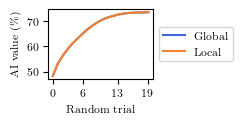

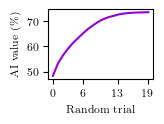

In [8]:
nr_trios_to_select = 20
landscape_trios = load_preselected_landscape_trios()

selected_trios = []
high_low_difference_sum = np.zeros(len(landscape_trios[0]["high_rewards"]))
for i in range(nr_trios_to_select):
    new_trio = None
    trio_score = np.inf
    for trio in landscape_trios:
        if trio in selected_trios:
            continue
        new_high_low_difference_sum = high_low_difference_sum + trio["high_rewards"] - trio["low_rewards"]
        new_trio_score = np.sum(np.abs(new_high_low_difference_sum))
        if new_trio_score < trio_score:
            new_trio = trio
            trio_score = new_trio_score
    selected_trios.append(new_trio)
    high_low_difference_sum += new_trio["high_rewards"] - new_trio["low_rewards"]

save_selected_landscape_trios(selected_trios, nr_trios_to_select)

filename_figure_high_low = f"../figures/advisor_high_low_comparison/selected_landscape_trios_high_low_performance.pdf"
filename_figure_average = f"../figures/advisor_high_low_comparison/selected_landscape_trios_performance.pdf"
performance_high = np.mean([trio["high_rewards"] for trio in selected_trios], axis=0)
performance_low = np.mean([trio["low_rewards"] for trio in selected_trios], axis=0)
plot_performance(filename_figure_high_low, filename_figure_average, performance_high, performance_low, len(performance_high), show=True)